In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import osmnx as ox
import numpy as np
import pandas as pd
from multiprocessing import Pool,cpu_count
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely import wkt
import glob
import time
import random
import sklearn
from sklearn.tree import DecisionTreeRegressor
from lib_garmin_elevation import *

0.04424643516540527


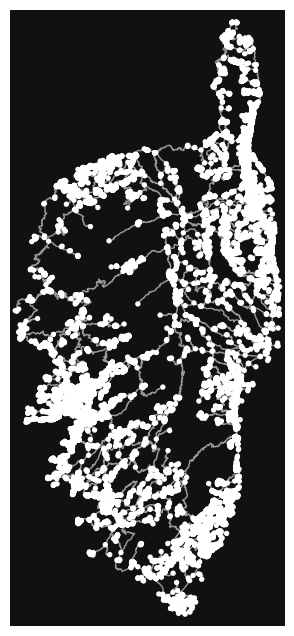

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
place_name='Corse, France'
G_osm=ox.graph_from_place(place_name,network_type='drive')
G_osm=to_multi_graph(G_osm)
crs=ox.graph_to_gdfs(G_osm,edges=False).estimate_utm_crs()
G_osm=ox.project_graph(G_osm,to_crs=crs)
t1=time.time()
add_missing_geometries(G_osm)
t2=time.time()
print(t2-t1)

ox.plot_graph(G_osm)


In [3]:
def parallelized_preprocess(file_paths):
    garmin_dfs=[preprocess(file_path,G_osm,crs=crs) for file_path in file_paths]
    return pd.concat(garmin_dfs)

In [4]:
GENERATE=True
navigation_df_path='./navigation_df.csv'
if GENERATE:
    t1=time.time()
    nb_cpu=cpu_count()-1
    file_paths=glob.glob('./garmin_activities/*.gpx')
    chunked_file_paths=chunk(file_paths,nb_cpu)
    with Pool(nb_cpu) as p:
        navigation_dfs=p.map(parallelized_preprocess,chunked_file_paths)
    navigation_df=pd.concat(navigation_dfs)
    navigation_df=navigation_df.to_crs('epsg:4326')
    navigation_df.to_csv(navigation_df_path,index=False)
    navigation_df=navigation_df.to_crs(crs)
    t2=time.time()
    print(t2-t1)
else:
    navigation_df=pd.read_csv(navigation_df_path)
    navigation_df['geometry']=navigation_df['geometry'].apply(wkt.loads)
    navigation_df=gpd.GeoDataFrame(navigation_df,geometry='geometry',crs='epsg:4326')
    navigation_df['time']=pd.to_datetime(navigation_df['time'])
    navigation_df['edge']=navigation_df['edge'].apply(eval)
    navigation_df=navigation_df.to_crs(crs)
navigation_df

reading file took 0.722169 s
estimating crs took 0.022053 s
reading file took 0.834389 s
estimating crs took 0.021046 s
reading file took 1.124899 s
estimating crs took 0.027874 s
reading file took 1.164937 s
estimating crs took 0.022624 s
reading file took 2.017678 s
estimating crs took 0.022281 s
reading file took 2.259219 s
estimating crs took 0.041185 s
projecting took  1.769295 s
reading file took 2.648658 s
estimating crs took 0.035982 s
projecting took  1.948878 s
projecting took  1.776632 s
adding segments took 0.200266 s
adding segments took 0.504249 s
projecting took  1.920872 s
adding segments took 0.381691 s
adding segments took 0.235873 s
reading file took 0.089367 s
estimating crs took 0.012596 s
reading file took 0.350156 s
estimating crs took 0.011419 s
projecting took  0.520962 s
reading file took 0.941869 s
estimating crs took 0.023912 s
adding segments took 0.148912 s
reading file took 0.585903 s
estimating crs took 0.025629 s
projecting took  1.401259 s
projecting t

,file_path,geometry,elevation,time,edge,edge_coordinate,pre_segment,orientation,segment
0,./garmin_activities/activity_12322559591.gpx,POINT (482452.154 4710449.517),8.200000,2023-09-05 13:57:31+00:00,"(51319395, 9064150112, 0)",406.639341,0,1.0,0
1,./garmin_activities/activity_12322559591.gpx,POINT (482455.064 4710445.288),30.200001,2023-09-05 13:57:32+00:00,"(51319395, 9064150112, 0)",411.773043,0,1.0,0
2,./garmin_activities/activity_12322559591.gpx,POINT (482458.498 4710440.297),32.400002,2023-09-05 13:57:33+00:00,"(51319395, 9064150112, 0)",417.831396,0,1.0,0
3,./garmin_activities/activity_12322559591.gpx,POINT (482461.864 4710435.404),33.000000,2023-09-05 13:57:34+00:00,"(51319395, 9064150112, 0)",423.769641,0,1.0,0
4,./garmin_activities/activity_12322559591.gpx,POINT (482464.925 4710430.956),33.400002,2023-09-05 13:57:35+00:00,"(51319395, 9064150112, 0)",429.169124,0,1.0,0
...,...,...,...,...,...,...,...,...,...
14392,./garmin_activities/albin_2.gpx,POINT (482312.549 4710652.407),69.000000,2021-04-01 14:31:34+00:00,"(51319395, 9064150112, 0)",160.359109,44,-1.0,83
14393,./garmin_activities/albin_2.gpx,POINT (482311.203 4710654.365),70.000000,2021-04-01 14:31:35+00:00,"(51319395, 9064150112, 0)",157.983103,44,-1.0,83
14394,./garmin_activities/albin_2.gpx,POINT (482310.766 4710655.000),70.000000,2021-04-01 14:31:36+00:00,"(51319395, 9064150112, 0)",157.212514,44,-1.0,83
14395,./garmin_activities/albin_2.gpx,POINT (482311.316 4710654.200),70.000000,2021-04-01 14:31:37+00:00,"(51319395, 9064150112, 0)",158.183261,44,1.0,84


In [5]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
G_navigation=build_multidigraph(G_osm,navigation_df)
t2=time.time()
print(t2-t1)


5.981278896331787


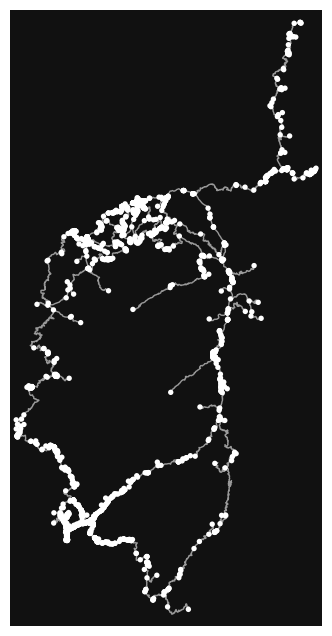

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
edges=sorted(navigation_df['edge'].unique(),key=lambda edge:G_osm.get_edge_data(*edge)['length'])
ox.plot_graph(nx.edge_subgraph(G_osm,edges))

0.00024175643920898438


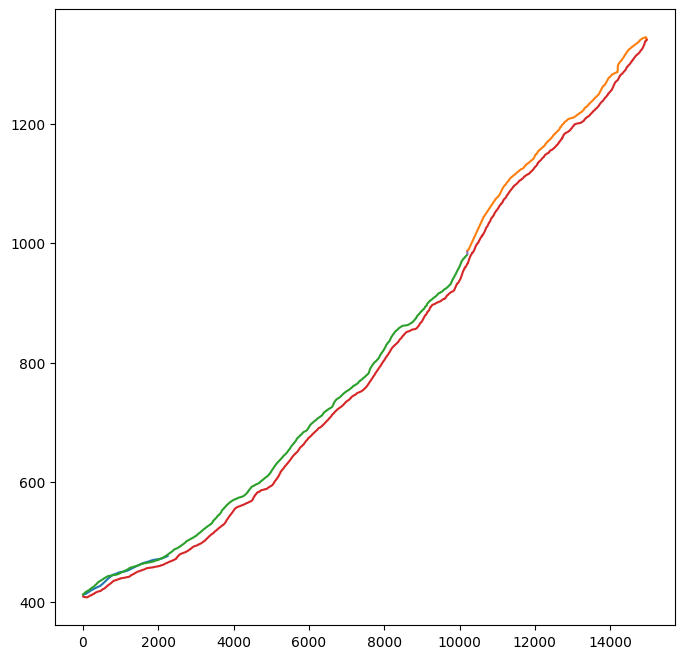

In [7]:
plt.rcParams['figure.figsize']=(8,8)
edge=edges[-6]
path=[edge]

t1=time.time()
meta_segments,_=get_meta_segments_along_path(path,G_navigation,G_osm)
t2=time.time()
print(t2-t1)
for elem in meta_segments:
    X,Y=elem['X'],elem['Y']
    plt.plot(X,Y)
    #plt.scatter(X[0],Y[0],c='g')
    #plt.scatter(X[-1],Y[-1],c='r')


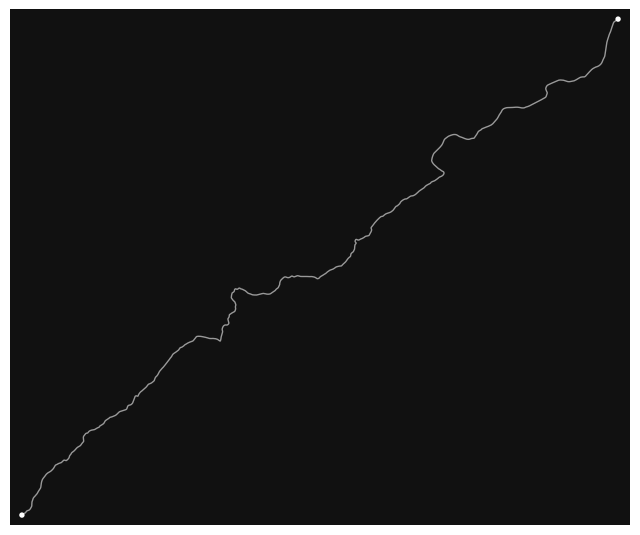

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(nx.edge_subgraph(G_osm,map(tuple,path[:])))

0.013479471206665039 0.04677557945251465


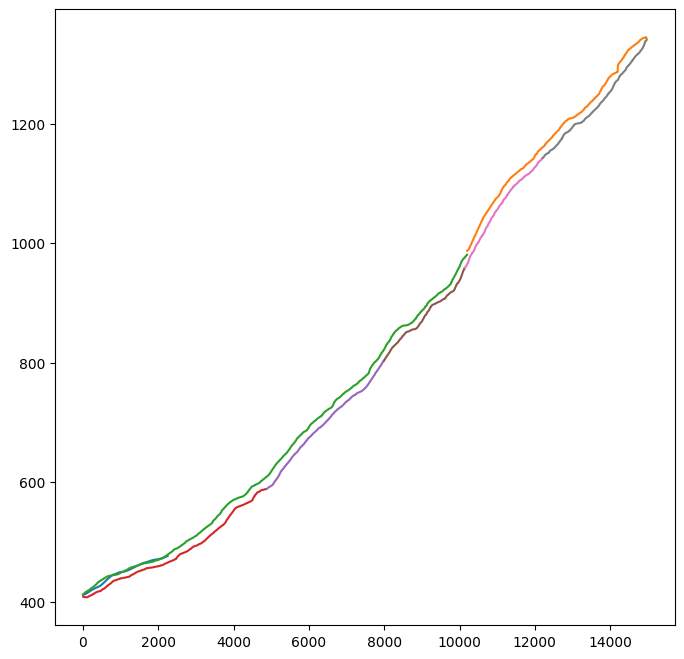

In [9]:
plt.rcParams['figure.figsize']=(8,8)
t1=time.time()
meta_segments=split_meta_segments(meta_segments,max_delta_T=900)
meta_segments=harmonize_meta_segments(meta_segments)
meta_segments=discard_outliers(meta_segments)
t2=time.time()
pairwise_shifts,affine_meta_segments=get_pairwise_shifts(meta_segments,overlay_threshold=0.25,)
t3=time.time()
print(t3-t2,t2-t1)
for meta_segment in meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])
for k in affine_meta_segments:
    meta_segment=meta_segments[k]
    plt.plot(meta_segment['X'],meta_segment['Y'],c='k')    

0.0001392364501953125


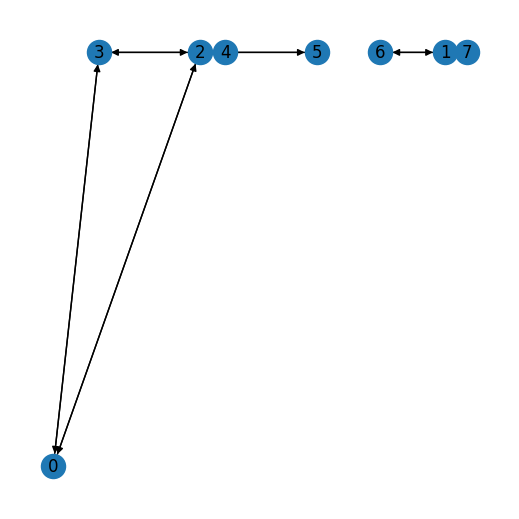

In [10]:
plt.rcParams['figure.figsize']=(5,5)

file_paths=list(np.unique(navigation_df['file_path']))
N=len(meta_segments)
t1=time.time()
shift_G=get_shifts_graph(pairwise_shifts,correlation_treshold=0.99)
t2=time.time()
print(t2-t1)

pos={k:(np.mean(meta_segments[k]['X']),file_paths.index(meta_segments[k]['file_path'])) for k in range(N)} 
nx.draw(shift_G,pos=pos,with_labels=True)

0.0012264251708984375


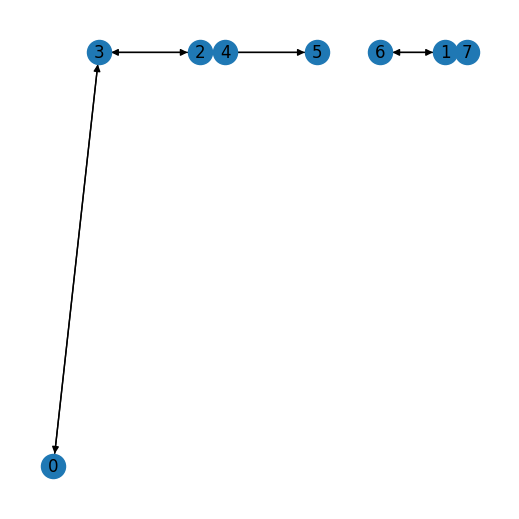

In [11]:
t1=time.time()
tree_edges=list(nx.minimum_spanning_edges(nx.Graph(shift_G),weight='weight',data=False))
tree_edges+=[(v,u) for u,v in tree_edges]
shift_tree=nx.edge_subgraph(shift_G,tree_edges)
t2=time.time()
print(t2-t1)
nx.draw(shift_tree,pos=pos,with_labels=True)

0.0008785724639892578


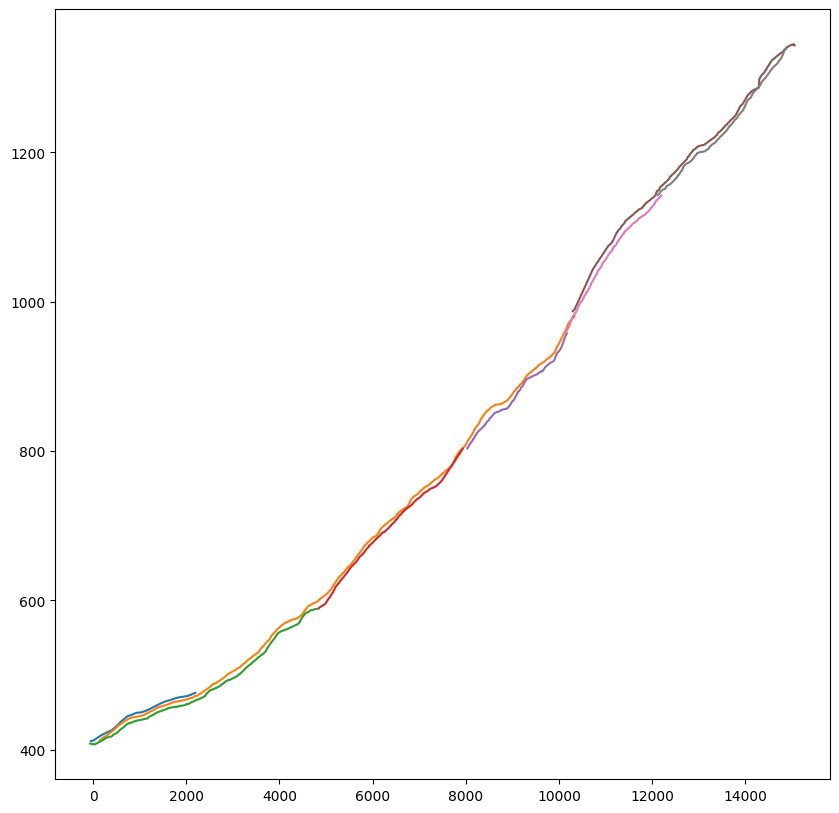

In [12]:
plt.rcParams['figure.figsize']=(10,10)
t1=time.time()
corrected_meta_segments=realign_meta_segments_from_tree(shift_tree,meta_segments,min_tree_components=1)
corrected_meta_segments+=[meta_segments[k] for k in affine_meta_segments]
t2=time.time()
print(t2-t1)
for meta_segment in corrected_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])



In [13]:
cover,extremities=get_cover(corrected_meta_segments,min_count=2)
len(cover)

3

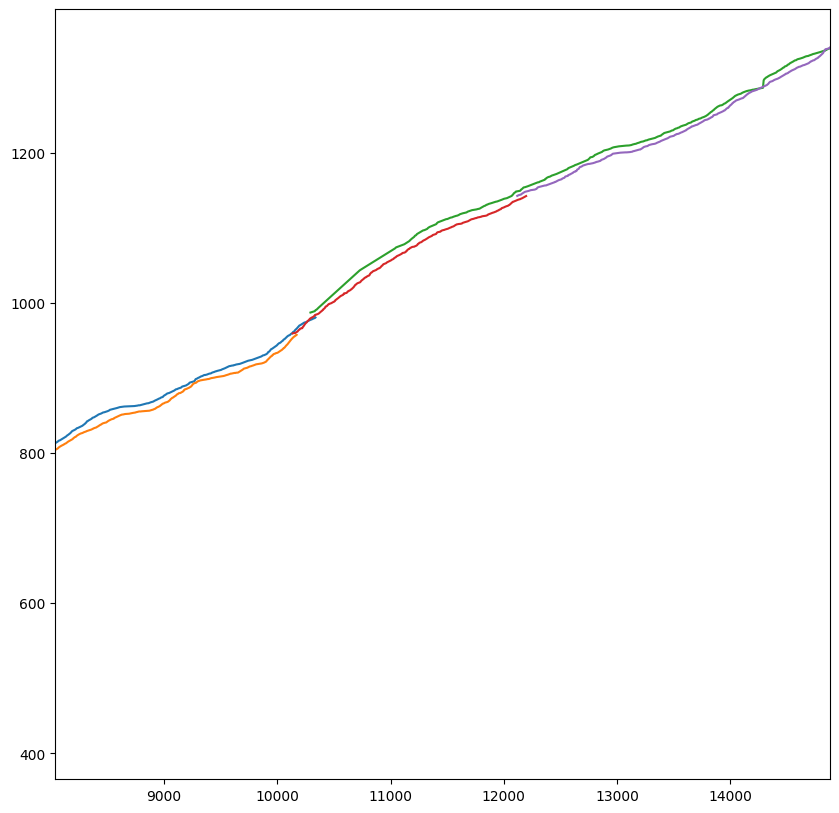

In [21]:
i=2
sub_meta_segments=[corrected_meta_segments[k] for k in cover[i]]
x_min,x_max=extremities[i]
plt.xlim(x_min,x_max)
for meta_segment in sub_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y'])    


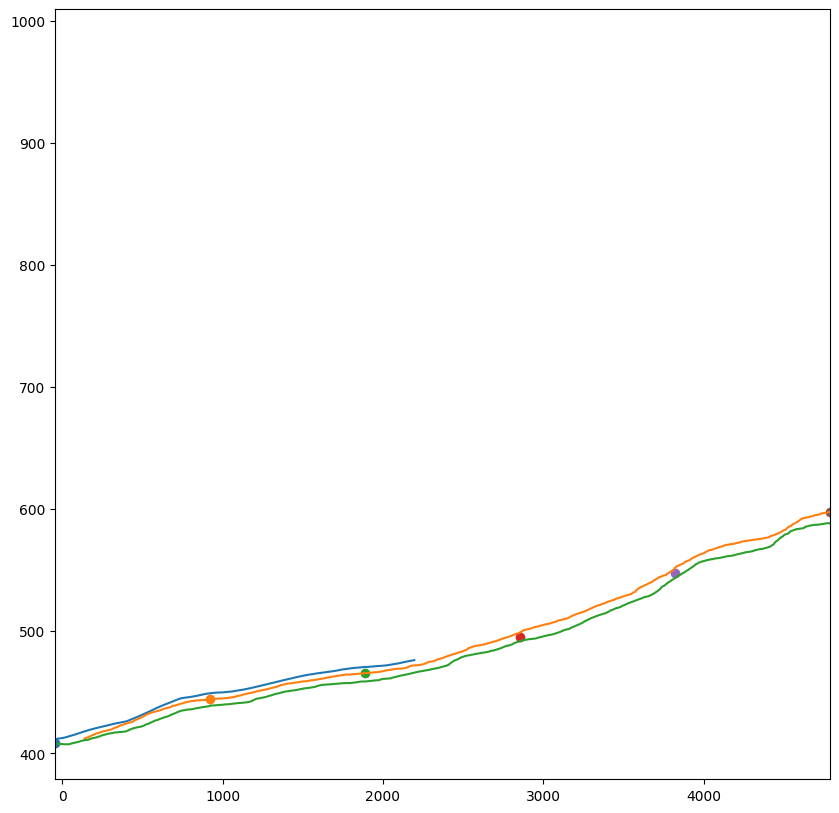

In [15]:
plt.xlim(x_min,x_max)
intermediate_distance=1000
intermediate_points=np.linspace(x_min,x_max,max(round((x_max-x_min)/intermediate_distance)+1,2))
for meta_segment in sub_meta_segments:
    plt.plot(meta_segment['X'],meta_segment['Y']) 
intermediate_elevations=get_intermediate_elevation(intermediate_points,sub_meta_segments)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))

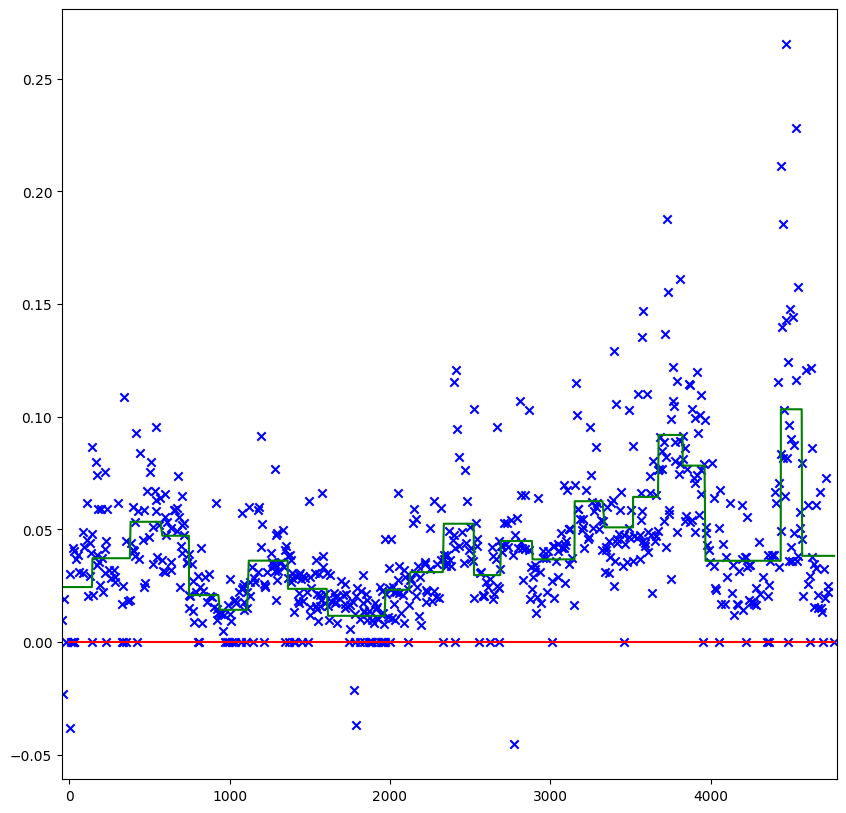

In [16]:
plt.xlim(x_min,x_max)
output=approximate_derivative(sub_meta_segments,x_min=x_min,x_max=x_max,
                                    min_samples_leaf=25,min_impurity_decrease=0.5*float('1e-6'))
if output is not None:
    X,dYdX,model=output
    Z=model.predict(X.reshape(-1,1))
    plt.scatter(X,dYdX,c='b',marker='x')
    plt.plot([0,X[-1]],[0,0],c='r')
    plt.plot(X,Z,c='g')


6.265671 m elevation difference on a 4.833454 kms long path


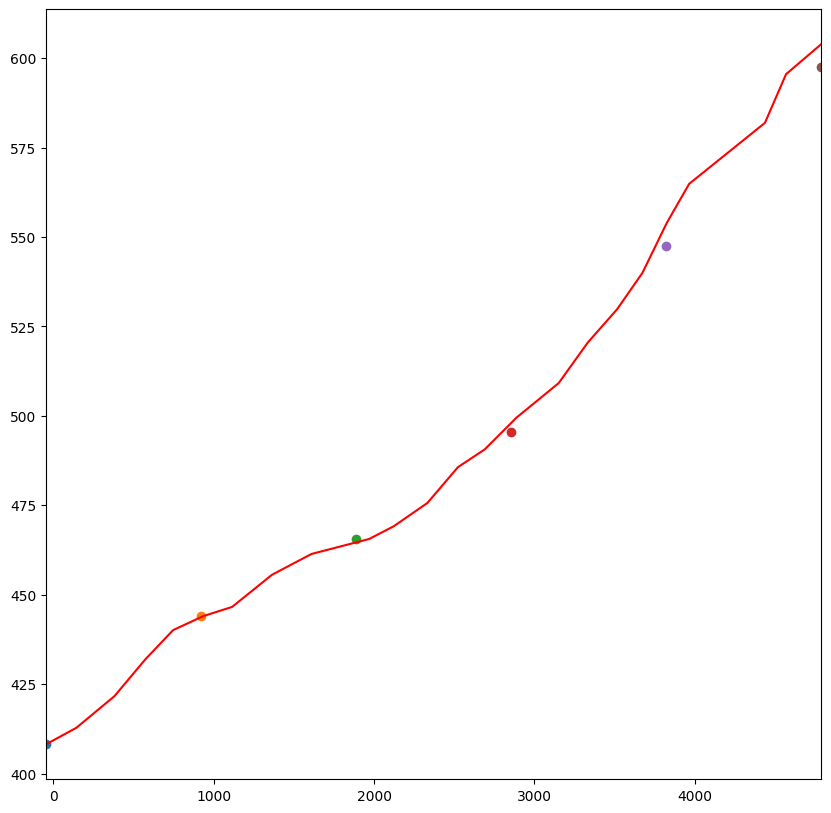

In [17]:
plt.xlim(x_min,x_max)
intervals=get_derivative_intervals(model.tree_)
intervals[0][0]=x_min
intervals[-1][1]=x_max
XX,YY=infer_curve_from_estimated_gradient(intervals,np.nanmedian(intermediate_elevations[0]))

plt.plot(XX,YY,c='r')
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
print('%f m elevation difference on a %f kms long path'%(YY[-1]-np.nanmedian(intermediate_elevations[-1]),(x_max-x_min)/1000))

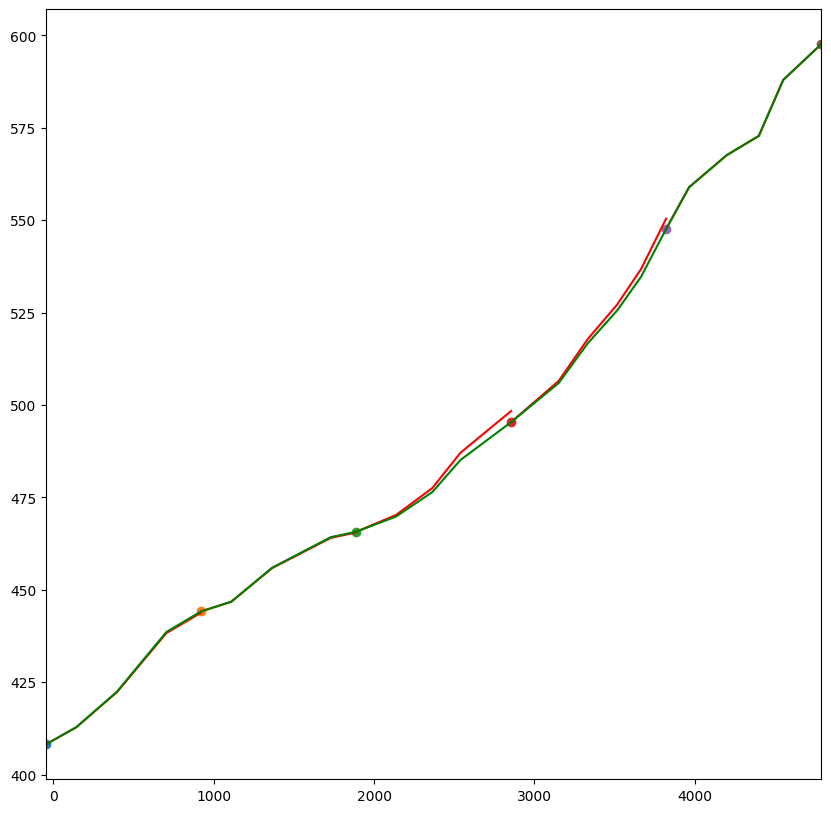

In [18]:
plt.xlim(x_min,x_max)
for k in range(len(intermediate_points)-1):
    x1,x2=intermediate_points[k],intermediate_points[k+1]
    output=approximate_derivative(sub_meta_segments,x_min=x1,x_max=x2)

    if output is not None:
        _,_,model=output
        intervals=get_derivative_intervals(model.tree_)
        intervals[0][0]=x1
        intervals[-1][1]=x2
        x,y=infer_curve_from_estimated_gradient(intervals,np.nanmedian(intermediate_elevations[k]))
        plt.plot(x,y,c='r')
        delta_expected=np.nanmedian(intermediate_elevations[k+1])-np.nanmedian(intermediate_elevations[k])
        y,_=adjust_curve_elevation(y,delta_expected)
        plt.plot(x,y,c='g')
        plt.scatter(intermediate_points[k],np.nanmedian(intermediate_elevations[k]))
plt.scatter(intermediate_points[-1],np.nanmedian(intermediate_elevations[-1]))


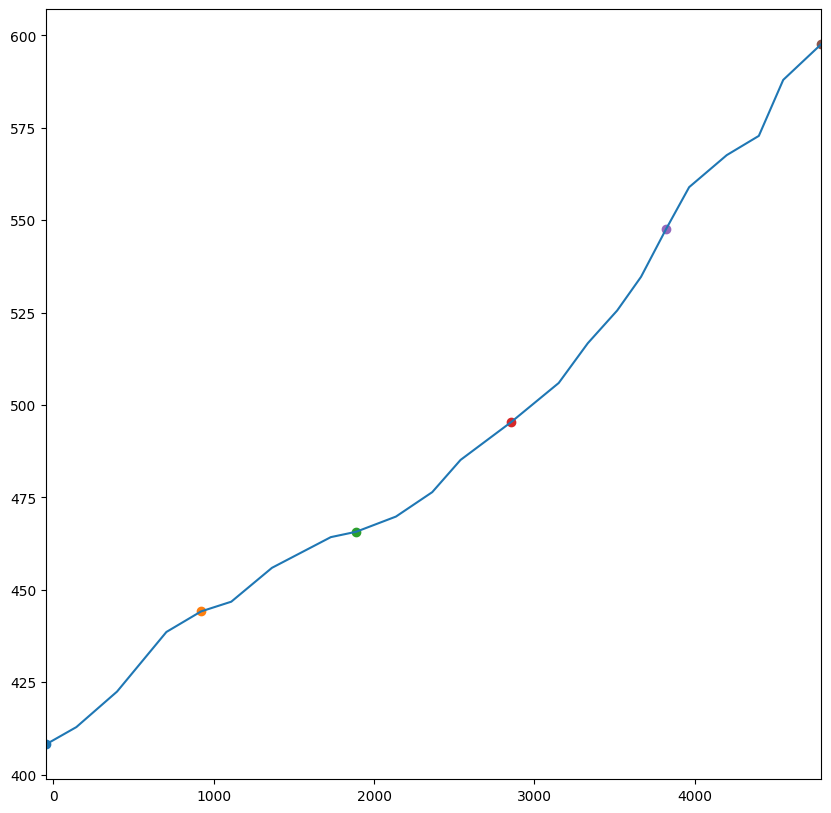

In [19]:
plt.xlim(x_min,x_max)
X,Y=approximate_elevation_profile(sub_meta_segments,x_min,x_max,intermediate_distance=1000)
X,Y=np.array(X),np.array(Y)
plt.plot(X,Y)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
    
